In [1]:
import sys, torch, os, json
print(f"pytorch version: {torch.__version__}")
import numpy as np
from tqdm import tqdm

module_rootdir = '.'
dataset_rootdir = '.'
label_rootdir = module_rootdir
sys.path.append(module_rootdir)

trained_weights_path = './model_weights/gnn/1718175257362/graph_based_detector.pt'
config_file_path = './configuration_radarscenes_gnn.yml'

from modules.set_configurations.set_config_gnn import config
from modules.data_utils.read_data import get_train_val_sequence_names, get_train_val_sequence_names_v2
from modules.set_configurations.set_param_for_inference_gnn import set_parameters_for_inference
from modules.data_utils.read_data import get_sequence_data
from modules.data_utils.labels import compute_new_labels_to_id_dict
from modules.data_utils.labels import compute_old_to_new_label_id_map
from modules.performance.detection_accuracy import compute_gt_and_pred_objects, compute_gt_and_pred_associations

save_model_performance_root_dir = './performance/object_classification'
os.makedirs(save_model_performance_root_dir, exist_ok=True)

pytorch version: 2.0.1


In [2]:
config_obj = config(config_file_path)
# train_sequence_names, test_sequence_names = get_train_val_sequence_names(dataset_rootdir, config_obj.dataset_path)
train_sequence_names, validation_sequence_names, test_sequence_names \
    = get_train_val_sequence_names_v2(dataset_rootdir, config_obj.dataset_path)

print('train sequences')
print(train_sequence_names)
print('test sequences')
print(test_sequence_names)
print('validation sequences')
print(validation_sequence_names)

INVALID_CLS_IDX = 5

train sequences
['sequence_1', 'sequence_2', 'sequence_3', 'sequence_4', 'sequence_8', 'sequence_10', 'sequence_11', 'sequence_12', 'sequence_13', 'sequence_16', 'sequence_17', 'sequence_18', 'sequence_20', 'sequence_22', 'sequence_25', 'sequence_26', 'sequence_27', 'sequence_28', 'sequence_29', 'sequence_32', 'sequence_33', 'sequence_34', 'sequence_35', 'sequence_36', 'sequence_37', 'sequence_38', 'sequence_39', 'sequence_43', 'sequence_46', 'sequence_47', 'sequence_49', 'sequence_50', 'sequence_52', 'sequence_55', 'sequence_56', 'sequence_57', 'sequence_60', 'sequence_61', 'sequence_62', 'sequence_66', 'sequence_67', 'sequence_69', 'sequence_70', 'sequence_71', 'sequence_72', 'sequence_75', 'sequence_76', 'sequence_78', 'sequence_80', 'sequence_81', 'sequence_83', 'sequence_84', 'sequence_86', 'sequence_87', 'sequence_88', 'sequence_91', 'sequence_92', 'sequence_94', 'sequence_95', 'sequence_96', 'sequence_97', 'sequence_98', 'sequence_100', 'sequence_101', 'sequence_102', 'sequence_

In [3]:
clustering_eps = 1.5

param_obj = set_parameters_for_inference(module_rootdir, config_obj, trained_weights_path)
device = param_obj['device']
grid = param_obj['grid']
detector = param_obj['detector']
detector.set_param_for_proposal_extraction(clustering_eps, compute_adj_mat_from_links=False) 

labels_to_id_dict = compute_new_labels_to_id_dict()
old_to_new_label_id_map = compute_old_to_new_label_id_map()

cluster_size_threshold = 0

pred_gt_association_eps_inv_iou = 1 - 0.3
pred_gt_association_eps_l2_norm = 1.0
pred_gt_association_eps = pred_gt_association_eps_inv_iou

CLASS_NAMES = ['CAR', 'PEDESTRIAN', 'PEDESTRIAN_GROUP', 'TWO_WHEELER', 'LARGE_VEHICLE', 'NONE', 'FALSE']

GPU is available. Good to go!


In [5]:
all_sequence_names = test_sequence_names #+ train_sequence_names

for sequence_name in all_sequence_names:

    scene_metadata, radar_mount_data, radar_data_all_scenes, odometry_data_all_scenes \
            = get_sequence_data(dataset_rootdir, config_obj.dataset_path, sequence_name, config_obj.window_size)

    print(f"processing {sequence_name} with {len(scene_metadata)} number of frames")

    gt_count_matrix = np.zeros((config_obj.num_classes, ), dtype=np.uint64)
    pred_count_matrix = np.zeros((config_obj.num_classes, ), dtype=np.uint64)
    confusion_matrix = np.zeros((config_obj.num_classes, config_obj.num_classes), dtype=np.uint64)

    for idx in tqdm(range(len(scene_metadata))):

        gt_and_pred_objects = compute_gt_and_pred_objects(
                idx,
                scene_metadata,
                radar_mount_data,
                radar_data_all_scenes,
                odometry_data_all_scenes,
                labels_to_id_dict,
                old_to_new_label_id_map,
                grid, 
                config_obj, 
                device,
                detector,
                cluster_size_threshold,
                detect_object_by_segmentation_output=True)
        
        gt_pred_associations = compute_gt_and_pred_associations(gt_and_pred_objects, pred_gt_association_eps)
        obj_class_gt_associated = gt_pred_associations['obj_class_gt_associated']
        obj_class_pred_associated = gt_pred_associations['obj_class_pred_associated']
        obj_class_gt = gt_pred_associations['obj_class_gt']
        obj_class_pred = gt_pred_associations['obj_class_pred']

        if obj_class_gt.shape[0] != 0:
                for i in range(obj_class_gt.shape[0]):
                        gt_count_matrix[obj_class_gt[i]] += 1

        if obj_class_pred.shape[0] != 0:
                for i in range(obj_class_pred.shape[0]):
                        pred_count_matrix[obj_class_pred[i]] += 1

        if obj_class_gt_associated.shape[0] != 0:
                for i in range(obj_class_gt_associated.shape[0]):
                        confusion_matrix[obj_class_gt_associated[i], obj_class_pred_associated[i]] += 1
                        
    file_name = sequence_name + '.json'
    file_name = os.path.join(save_model_performance_root_dir, file_name)

    performance_data = {}
    performance_data['class_names'] = CLASS_NAMES
    performance_data['confusion_matrix'] = confusion_matrix.tolist()
    performance_data['gt_count_matrix'] = gt_count_matrix.tolist()
    performance_data['pred_count_matrix'] = pred_count_matrix.tolist()

    with open(file_name, 'w') as json_file:
        json.dump(performance_data, json_file, indent=4)

processing sequence_82 with 4196 number of frames


100%|██████████| 4196/4196 [01:02<00:00, 66.84it/s] 


processing sequence_7 with 6205 number of frames


100%|██████████| 6205/6205 [03:56<00:00, 26.19it/s] 


processing sequence_9 with 4748 number of frames


100%|██████████| 4748/4748 [04:42<00:00, 16.84it/s]


processing sequence_90 with 1489 number of frames


100%|██████████| 1489/1489 [01:12<00:00, 20.58it/s]


processing sequence_15 with 1061 number of frames


100%|██████████| 1061/1061 [00:44<00:00, 24.04it/s] 


processing sequence_21 with 5801 number of frames


100%|██████████| 5801/5801 [01:30<00:00, 64.12it/s] 


processing sequence_23 with 6812 number of frames


100%|██████████| 6812/6812 [02:08<00:00, 52.85it/s]


processing sequence_103 with 2044 number of frames


100%|██████████| 2044/2044 [00:36<00:00, 55.69it/s]


processing sequence_105 with 6469 number of frames


100%|██████████| 6469/6469 [37:57<00:00,  2.84it/s]  


processing sequence_30 with 4317 number of frames


100%|██████████| 4317/4317 [01:16<00:00, 56.68it/s]


processing sequence_113 with 10804 number of frames


100%|██████████| 10804/10804 [17:53<00:00, 10.06it/s]


processing sequence_115 with 8416 number of frames


100%|██████████| 8416/8416 [07:34<00:00, 18.53it/s] 


processing sequence_40 with 2992 number of frames


100%|██████████| 2992/2992 [01:27<00:00, 34.37it/s]


processing sequence_41 with 4617 number of frames


100%|██████████| 4617/4617 [02:56<00:00, 26.20it/s]


processing sequence_44 with 4515 number of frames


100%|██████████| 4515/4515 [01:51<00:00, 40.53it/s]


processing sequence_45 with 6989 number of frames


100%|██████████| 6989/6989 [04:58<00:00, 23.44it/s]


processing sequence_121 with 1215 number of frames


100%|██████████| 1215/1215 [01:16<00:00, 15.93it/s]


processing sequence_51 with 1879 number of frames


100%|██████████| 1879/1879 [01:14<00:00, 25.39it/s]


processing sequence_54 with 966 number of frames


100%|██████████| 966/966 [00:26<00:00, 35.84it/s]


processing sequence_131 with 2953 number of frames


100%|██████████| 2953/2953 [06:18<00:00,  7.80it/s]


processing sequence_59 with 2575 number of frames


100%|██████████| 2575/2575 [01:44<00:00, 24.62it/s]


processing sequence_151 with 3682 number of frames


100%|██████████| 3682/3682 [00:56<00:00, 65.31it/s]


processing sequence_64 with 6754 number of frames


100%|██████████| 6754/6754 [04:45<00:00, 23.68it/s]


processing sequence_65 with 6694 number of frames


100%|██████████| 6694/6694 [03:31<00:00, 31.66it/s]


processing sequence_144 with 7368 number of frames


100%|██████████| 7368/7368 [07:36<00:00, 16.12it/s]  


processing sequence_74 with 5607 number of frames


100%|██████████| 5607/5607 [01:50<00:00, 50.79it/s]


processing sequence_154 with 5632 number of frames


100%|██████████| 5632/5632 [01:20<00:00, 69.94it/s]


processing sequence_77 with 4296 number of frames


100%|██████████| 4296/4296 [03:59<00:00, 17.97it/s]


## Test Dataset

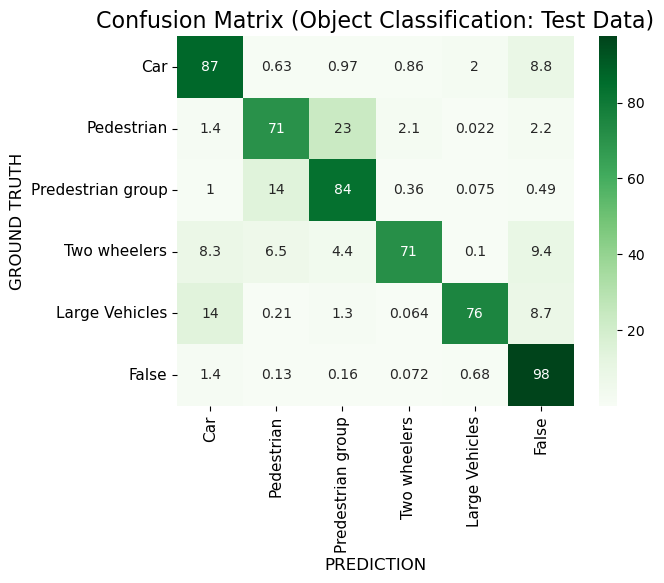

[[86.66  0.63  0.97  0.86  2.05  8.82]
 [ 1.44 70.8  23.48  2.08  0.02  2.17]
 [ 1.03 14.27 83.78  0.36  0.07  0.49]
 [ 8.26  6.47  4.4  71.41  0.1   9.36]
 [13.97  0.21  1.3   0.06 75.8   8.65]
 [ 1.44  0.13  0.16  0.07  0.68 97.51]]
precision:  [0.7  0.72 0.78 0.74 0.39 0.99]
recall:  [0.86 0.62 0.79 0.7  0.74 0.72]


In [3]:
gt_count_matrix_sum = np.zeros((config_obj.num_classes, ), dtype=np.uint64)
pred_count_matrix_sum = np.zeros((config_obj.num_classes, ), dtype=np.uint64)
confusion_matrix_sum = np.zeros((config_obj.num_classes, config_obj.num_classes), dtype=np.uint64)
INVALID_CLS_IDX = 5

for sequence_name in test_sequence_names:

    file_path = os.path.join(save_model_performance_root_dir, sequence_name + '.json')
    with open(file_path, 'r') as file:
        performance = json.load(file)

    confusion_matrix_sum += np.array(performance['confusion_matrix'], dtype=np.uint64)
    gt_count_matrix_sum += np.array(performance['gt_count_matrix'], dtype=np.uint64)
    pred_count_matrix_sum += np.array(performance['pred_count_matrix'], dtype=np.uint64)

gt_count_matrix_sum = np.delete(gt_count_matrix_sum, INVALID_CLS_IDX, axis=0)
pred_count_matrix_sum = np.delete(pred_count_matrix_sum, INVALID_CLS_IDX, axis=0)
confusion_matrix_sum = np.delete(confusion_matrix_sum, INVALID_CLS_IDX, axis=0)
confusion_matrix_sum = np.delete(confusion_matrix_sum, INVALID_CLS_IDX, axis=1)

# normalized confusion matrix
normalized_confusion_matrix = confusion_matrix_sum / np.sum(confusion_matrix_sum, axis=-1, keepdims=True) * 100

# precision & recall
idx = np.arange(confusion_matrix_sum.shape[0])
precision = confusion_matrix_sum[idx, idx] / pred_count_matrix_sum
recall = confusion_matrix_sum[idx, idx] / gt_count_matrix_sum

import seaborn as sns
import matplotlib.pyplot as plt

CLASS_NAMES = ['Car', 'Pedestrian', 'Predestrian group', 'Two wheelers', 'Large Vehicles', 'None', 'False']
CLASS_NAMES.pop(INVALID_CLS_IDX)
hmap = sns.heatmap(data=normalized_confusion_matrix, annot=True, cmap='Greens')
hmap.set_title('Confusion Matrix (Object Classification: Test Data)', size=16)
hmap.set_xlabel('PREDICTION', size=12)
hmap.set_ylabel('GROUND TRUTH', size=12)
hmap.xaxis.set_ticklabels(CLASS_NAMES, rotation=90, size=11)
hmap.yaxis.set_ticklabels(CLASS_NAMES, rotation=0, size=11)
fig = hmap.get_figure()
plt.show()

np.set_printoptions(suppress=True, precision=2)
print(normalized_confusion_matrix)
print('precision: ', precision)
print('recall: ', recall)

## Train Dataset

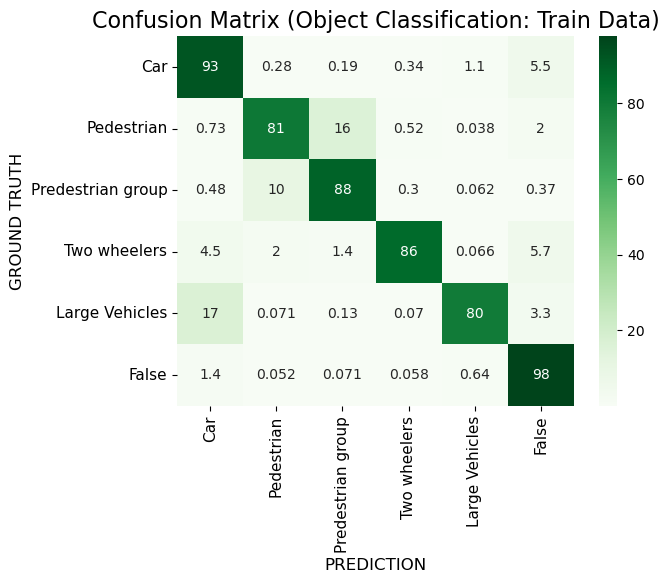

[[92.6   0.28  0.19  0.34  1.11  5.48]
 [ 0.73 80.95 15.77  0.52  0.04  1.98]
 [ 0.48 10.47 88.31  0.3   0.06  0.37]
 [ 4.54  2.03  1.43 86.24  0.07  5.69]
 [16.62  0.07  0.13  0.07 79.78  3.33]
 [ 1.39  0.05  0.07  0.06  0.64 97.79]]
precision:  [0.74 0.82 0.83 0.87 0.52 1.  ]
recall:  [0.92 0.66 0.82 0.86 0.79 0.71]


In [4]:
gt_count_matrix_sum = np.zeros((config_obj.num_classes, ), dtype=np.uint64)
pred_count_matrix_sum = np.zeros((config_obj.num_classes, ), dtype=np.uint64)
confusion_matrix_sum = np.zeros((config_obj.num_classes, config_obj.num_classes), dtype=np.uint64)
INVALID_CLS_IDX = 5

for sequence_name in train_sequence_names:

    file_path = os.path.join(save_model_performance_root_dir, sequence_name + '.json')
    with open(file_path, 'r') as file:
        performance = json.load(file)

    confusion_matrix_sum += np.array(performance['confusion_matrix'], dtype=np.uint64)
    gt_count_matrix_sum += np.array(performance['gt_count_matrix'], dtype=np.uint64)
    pred_count_matrix_sum += np.array(performance['pred_count_matrix'], dtype=np.uint64)

gt_count_matrix_sum = np.delete(gt_count_matrix_sum, INVALID_CLS_IDX, axis=0)
pred_count_matrix_sum = np.delete(pred_count_matrix_sum, INVALID_CLS_IDX, axis=0)
confusion_matrix_sum = np.delete(confusion_matrix_sum, INVALID_CLS_IDX, axis=0)
confusion_matrix_sum = np.delete(confusion_matrix_sum, INVALID_CLS_IDX, axis=1)
    
# normalized confusion matrix
normalized_confusion_matrix = confusion_matrix_sum / np.sum(confusion_matrix_sum, axis=-1, keepdims=True) * 100

# precision & recall
idx = np.arange(confusion_matrix_sum.shape[0])
precision = confusion_matrix_sum[idx, idx] / pred_count_matrix_sum
recall = confusion_matrix_sum[idx, idx] / gt_count_matrix_sum

import seaborn as sns
import matplotlib.pyplot as plt

CLASS_NAMES = ['Car', 'Pedestrian', 'Predestrian group', 'Two wheelers', 'Large Vehicles', 'None', 'False']
CLASS_NAMES.pop(INVALID_CLS_IDX)
hmap = sns.heatmap(data=normalized_confusion_matrix, annot=True, cmap='Greens')
hmap.set_title('Confusion Matrix (Object Classification: Train Data)', size=16)
hmap.set_xlabel('PREDICTION', size=12)
hmap.set_ylabel('GROUND TRUTH', size=12)
hmap.xaxis.set_ticklabels(CLASS_NAMES, rotation=90, size=11)
hmap.yaxis.set_ticklabels(CLASS_NAMES, rotation=0, size=11)
fig = hmap.get_figure()
plt.show()

np.set_printoptions(suppress=True, precision=2)
print(normalized_confusion_matrix)
print('precision: ', precision)
print('recall: ', recall)